# Feature engineering

This notebook takes care of the feature engineering part, in particular we're gonna add 3 new features to the dataset.

In [15]:
import pandas as pd
from os import path
import numpy as np

RACES_PATH=path.join("..","dataset","races_cleaned.csv")
races_df=pd.read_csv(RACES_PATH)

CYCLISTS_PATH=path.join("..","dataset","cyclists_cleaned.csv")
cyclist_df=pd.read_csv(CYCLISTS_PATH)

## before starting the analysis

As we observed from the original dataset we can see that climb_total is heavily related to the values of the profile, so we can try to use that and gain some insight in the meaning of the five categories in the profile and see how they map to the ones specified in the dataset description.

first of all we used the sturge rule to determine the number of bins necessary, after determining the number of bins we plot them in a grouped bar  plot as above, as  we can see some intersting information is already visible affter apply the log scale to make easy visualizing differences for small values since we are on different scales.

On the right side we observe that values 1, 2 and 3 are never present in the last 3 bins with the highest climb totals, assuming high climb totals correspond to mountains or high mountains we can say that 1,2,3 can be restricted to 'flat' and 'hilly' where climb totals tend to be low.

Plotting in original scale we see that category 3 is heavily present in the first bin this suggests it to be the 'flat' category.
From th original scale we also see that category 1 is very present in the first lower half of the bins and disappears when climb total goes up it seems to be reasonable that it is 'hilly' category(basically slightly higher than the others but doesn't make it to higher climb totals where mountain and high mountains are located).

2 displays a behavior similar to 3 and 1 it is not clear if it can ba attribute to flat or hilly given the fact that it manages to reach ighe climb totals bins like 3 it seems resonable to attribute it to hilly.

finally 4 can be attributed to 'montainous' and 5 to 'high mountains' this is because 4 is always present but way less than 5 at higher climb total bins.

This is the final mapping:
- 1,2 -> 'hilly'
- 3   -> 'flat'
- 4   -> 'montainous'
- 5   -> 'high mountains'

Such mapping is gonna be used to attribute a difficulty to each category in later parts of the analysis.

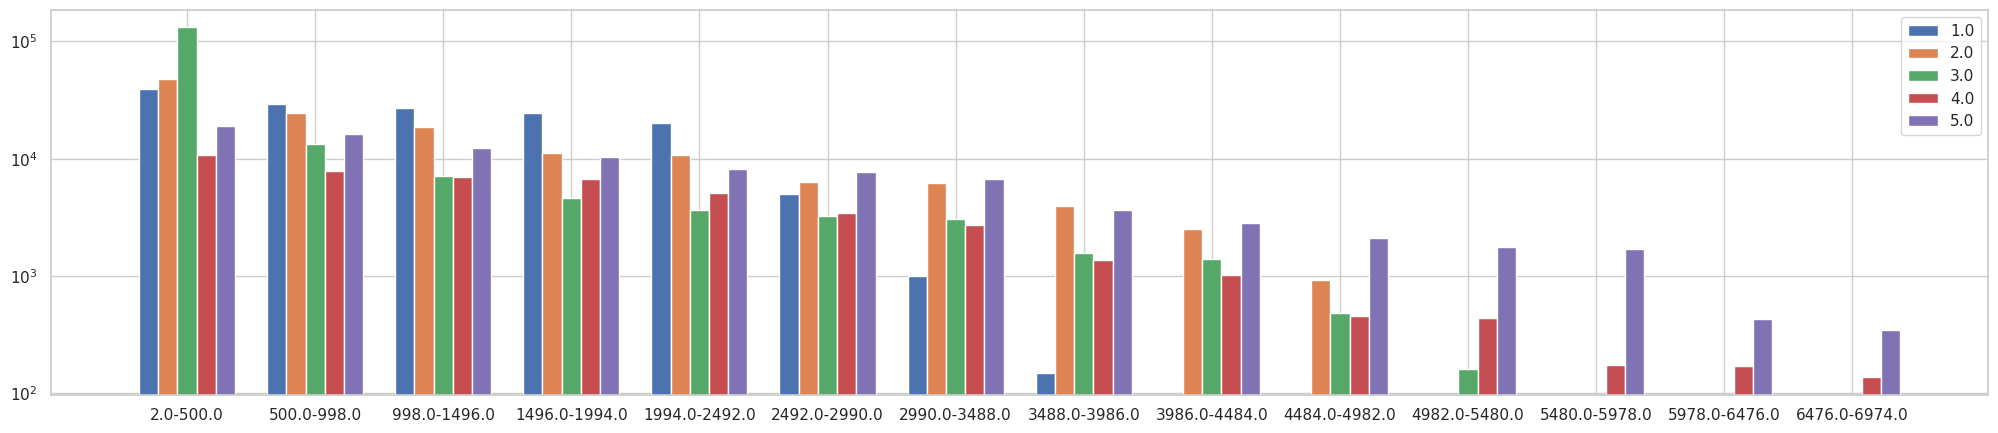

In [16]:
import matplotlib.pyplot as plt
import itertools as it
def plot_profile_distributons(races_df,log_flag=False):
    val=races_df['climb_total']
    n_bins=int(np.ceil(np.log( len(races_df))+1))
    bins=np.linspace(races_df['climb_total'].min(),races_df['climb_total'].max(),num=n_bins)
    bins_labels=list(map(lambda x: f"{x[0]}-{x[1]}",it.pairwise(bins)))

    width=0.15
    plt.figure(figsize=(25,5))

    x_axis=np.array(range(len(bins_labels)))

    for i,(k,g) in enumerate(races_df.groupby('profile')):
        binned=pd.cut(g['climb_total'],bins=bins,labels=bins_labels)
        plt.bar(x_axis+(i-2)*width,binned.value_counts().values,width=width,label=k)
    plt.xticks(x_axis,bins_labels)
    if log_flag:plt.yscale('log')
    plt.legend()
    #plt.show()
plot_profile_distributons(races_df,True)

without log scale


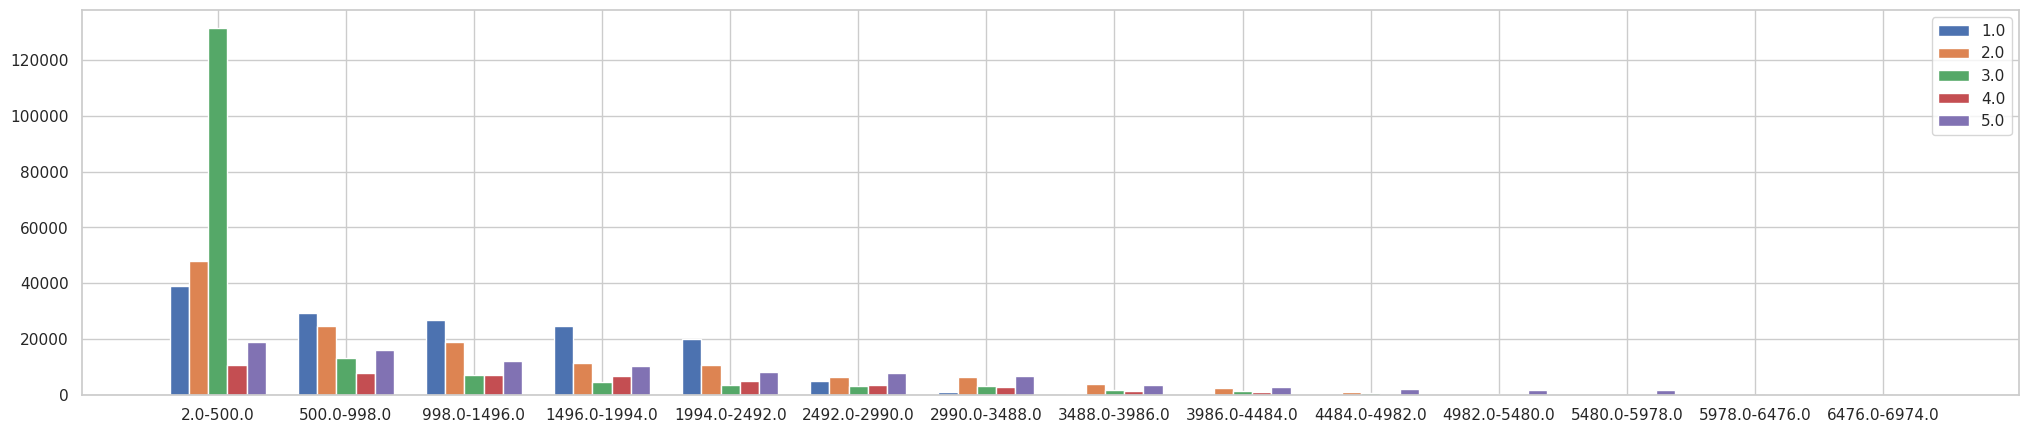

In [17]:
print("without log scale")
plot_profile_distributons(races_df)



Before analyzing the features we developed it is important to note that our main entities to be analyzed are races_df and cyclists, some features depends only on the cyclists, others only on the race and some on both to highlight such relationship we specify this in function like manner `features(entity)`. Also during the analysis much more features emerged to be necessary in order to determine the original 3 ones we developed.

## engineered features

The features we came up with are:

### classification by climbing efficiency
We want to get a ratio between the climb total and the length, this  can help us understand better the performances for cyclists on different kind of slopeness on average for the race.
$$
climbing\_ efficiency(race)= \frac{climb\_ total(race)(m)}{length(race)(KM)\times 1000}
$$
Note: length is multiplied by 1000 to get the same unit as the length

### classification by competitive age
We want to calculate the difference the age a cyclist has at the time of the race, this is useful because we might track the performances  of a single cyclist in multiple races across time and determine,if possible, if there are ages that are more performant that others or any kind of pattern across ages.
$$
competitive\_age(cyclist,race)=current\_ race \_ date(race) - cyclist\_ age(cyclist)
$$

### classification by convenience
This one serves to estimate the difficulty an athlete might have when facing certain stages, the important factors are
    - the difficulty of the terrain quantified by the terrain\_score which is the weight sum of the difficulty of each profile type for a certain race, the elements being weighted are the difficulties attributed to each profile type and the weights are determined for each race using the percentage of time the profile appears.
    - the age of the athlete at the time of the race i.e. the competitive age
    - the BMI of the athlete


The rationale is that a person that is older, overweight and deals with a difficult race has a lot more difficulty than another that is in shape, younger for the same race.
$$
terrain\_score(race) = \sum_i\frac{( \# \text{of times terrain } i \text{ appears in the race}) }{( \# \text{of stages for the race})}*(\text{terrain $i$ difficulty})
$$
$$
difficulty(cyclist,race)=climbing\_ efficiency(race)*terrain \_ score(race) * BMI(cyclist) * competitive \_ age(cyclist)
$$

### classification by difficulty
A ratio between points and difficulty, basically how much we gain from participating on certain races. The points of this feature is to find if there is any cyclist that tries to maximize the points gained while partecipating to the least difficult races or a brave one that goes to partecipate in difficult races to the it's capabilities and so on with any kind of behavioral pattern we can deduct.
$$
convenience\_ score(cyclist,age)=\frac{points(cyclist)}{difficulty(cyclist,age)}
$$

Note: the type of terrain is also important however in the dataset it is very noisy given that only is_tarmac is available and other values are difficult to determine so it is not considered inside the formulas.

In [18]:
import numpy as np

races_df['climbing_efficiency']=(races_df['climb_total'])/races_df['length']
races_df['date']=pd.to_datetime(races_df['date'])

years_to_sub=races_df.merge(cyclist_df,left_on="cyclist",right_on="_url",how='inner')['birth_year'].astype('int32')
races_df['competitive_age']=races_df['date'].dt.year-years_to_sub

#profile types difficulty for terrain difficulty estimation
terrain_difficulty={
    1:100,
    2:100,
    3:300,
    4:400,
    5:500
}

#extract name, and stage. Year can be deducted from the date feature
url_df=races_df['_url'].str.split('/',expand=True)
url_df.rename(columns={0:'name',1:'year',2:'stage'},inplace=True)
races_df['std_name']=url_df['name']
races_df['stage']=url_df['stage']

#group races by (race_name,year)
stages_grouping=races_df.groupby(['std_name',races_df.date.dt.year])

#calculate components of the difficulty formula coming from the race
profile_difficulty=races_df['profile'].map(terrain_difficulty)
profile_counting=stages_grouping['profile'].transform('size')
profile_freqs=stages_grouping['profile'].value_counts().reset_index(name='prof_freqs')
profile_freqs=races_df.merge(profile_freqs,left_on=['std_name',races_df.date.dt.year],right_on=['std_name','date'],how='inner')['prof_freqs']

# calculate components of the  difficulty formula coming from the cyclist
cyclists_physicals=races_df.merge(cyclist_df,left_on='cyclist',right_on='_url',how='inner')[['weight','height']]
cyclist_df['bmi']=cyclist_df['weight'] / (cyclist_df['height']/100) ** 2
cyclist_bmi=races_df.merge(cyclist_df,left_on=['cyclist'],right_on=['_url'],how='inner')['bmi']

diff_terms_df=pd.DataFrame()

# gather the terms to calculate difficulty
diff_terms_df['norm_bmi']=cyclist_bmi
diff_terms_df['norm_age']=races_df['competitive_age']
diff_terms_df['norm_terrain_diff']=((profile_freqs/profile_counting)*profile_difficulty)+1

#calculate formula,difficulty score and remove useless columns
races_df['difficulty']= diff_terms_df['norm_bmi']*diff_terms_df['norm_age']*diff_terms_df['norm_terrain_diff']
# avoid diving by 0 in convenience score calculation
races_df['difficulty']+=1

races_df['convenience_score']= races_df['points']/races_df['difficulty']
races_df['convenience_score']= (races_df['convenience_score']-races_df['convenience_score'].min())/(races_df['convenience_score'].max()-races_df['convenience_score'].min())
# as per the description of the dataset the hour of start is noisy and irrelevant, therefore it is evicted
races_df['date']=races_df['date'].dt.date
# url and name are to be dropped since we don't need them anymore
races_df=races_df.drop(columns=['_url','name'])

### Classification of the races using a scoring system

In [19]:
races_df['profile_norm'] = (races_df['profile'] - races_df['profile'].min()) / (races_df['profile'].max() - races_df['profile'].min())
races_df['climb_total_norm'] = (races_df['climb_total'] - races_df['climb_total'].min()) / (races_df['climb_total'].max() - races_df['climb_total'].min())
races_df['length_norm'] = (races_df['length'] - races_df['length'].min()) / (races_df['length'].max() - races_df['length'].min())

For this feature we denote as $\text{feature\_name}_{norm}$ the min-max rescaling of the feature.

After that, we calculate the score for the difficulty and classify each race by the score as follows:
$$ difficulty\_score(race) = profile_{norm}(race) + climb\_total_{norm}(race) + length_{norm}(race) $$

In [20]:
races_df['difficulty_score'] = races_df['profile_norm'] + races_df['climb_total_norm'] + races_df['length_norm']

def classify_difficulty(score):
    if score <= 1:
        return "easy"
    elif 1 < score <= 2:
        return "moderate"
    elif 2 < score <= 3:
        return "hard"
    else:
        return "extreme"

races_df['difficulty_level'] = races_df['difficulty_score'].apply(classify_difficulty)

races_df.drop(columns=['profile_norm', 'climb_total_norm', 'length_norm'], inplace=True)
races_df.head()


,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,climbing_efficiency,competitive_age,std_name,stage,difficulty,convenience_score,difficulty_score,difficulty_level
0,100.0,162000.0,1101.0,1.0,1241,1978-07-05,0,sean-kelly,22.0,True,vini-ricordi-pinarello-sidermec-1986,0.0,0.006796,22,tour-de-france,stage-6,29292.971414,0.020686,0.635375,easy
1,100.0,162000.0,1101.0,1.0,1241,1978-07-05,1,gerrie-knetemann,27.0,True,norway-1987,0.0,0.006796,27,tour-de-france,stage-6,10253.271312,0.059106,0.635375,easy
2,100.0,162000.0,1101.0,1.0,1241,1978-07-05,2,rene-bittinger,24.0,True,france-1978,0.0,0.006796,24,tour-de-france,stage-6,6932.135759,0.087424,0.635375,easy
3,100.0,162000.0,1101.0,1.0,1241,1978-07-05,3,joseph-bruyere,30.0,True,navigare-blue-storm-1993,0.0,0.006796,30,tour-de-france,stage-6,5985.755482,0.101247,0.635375,easy
4,100.0,162000.0,1101.0,1.0,1241,1978-07-05,4,sven-ake-nilsson,27.0,True,spain-1991,0.0,0.006796,27,tour-de-france,stage-6,5084.548657,0.119193,0.635375,easy


### Interaction between the weight and the performance

(To be improved) This new feature combines `weight` and `position` to calculate a performance index for each race in the dataset.
$$ performance\_index(race,cyclist) = (1- weight_{norm}(cyclist)) * (1 - position_{norm}(race)) $$

In [21]:


datasetpath = path.join('..', 'dataset','cyclists_cleaned.csv')
cyclists = pd.read_csv(datasetpath)
merged_df = races_df.merge(cyclists[['weight', '_url']], left_on='cyclist', right_on='_url', how='left')

merged_df['weight_norm'] = (merged_df['weight'] - merged_df['weight'].min()) / (merged_df['weight'].max() - merged_df['weight'].min())
merged_df['position_norm'] = (merged_df['position'] - merged_df['position'].min()) / (merged_df['position'].max() - merged_df['position'].min())

merged_df['performance_index'] = (1 - merged_df['position_norm']) * (1 - merged_df['weight_norm'])

correlation = merged_df[['performance_index', 'weight_norm', 'position_norm']].corr()

print("Correlation between performance index, weight, and position:")
print(correlation)

merged_df[['position', 'weight', 'weight_norm', 'position_norm', 'performance_index']].head()
races_df['performance_index'] = merged_df['performance_index']


Correlation between performance index, weight, and position:
                   performance_index  weight_norm  position_norm
performance_index           1.000000    -0.713476      -0.727131
weight_norm                -0.713476     1.000000       0.098442
position_norm              -0.727131     0.098442       1.000000


### See the most advantageous races

Now we calculate for each row the ratio between the points and the difficulty score. This ratio will be used to see which are the most advantageous races for the riders over the years.

$$ gain\_ratio(race) = \frac{points(race)}{difficulty\_score(race)} $$

In [22]:
races_df['gain_ratio'] = (races_df['points']/races_df['difficulty_score'])
races_df[['points','difficulty_score', 'difficulty_level', 'gain_ratio']].drop_duplicates().head()

,points,difficulty_score,difficulty_level,gain_ratio
0,100.0,0.635375,easy,157.387288
106,80.0,2.377975,hard,33.642066
271,100.0,0.488587,easy,204.671737
426,50.0,0.855043,easy,58.476618
545,100.0,1.606011,moderate,62.266071


## Data understanding for the new features

First of all, we analyze the distribution of the new features in the dataset.

In [23]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np
seaborn.set_theme(style="whitegrid") 
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   points               589865 non-null  float64
 1   length               589865 non-null  float64
 2   climb_total          589865 non-null  float64
 3   profile              589865 non-null  float64
 4   startlist_quality    589865 non-null  int64  
 5   date                 589865 non-null  object 
 6   position             589865 non-null  int64  
 7   cyclist              589865 non-null  object 
 8   cyclist_age          589865 non-null  float64
 9   is_tarmac            589865 non-null  bool   
 10  cyclist_team         589865 non-null  object 
 11  delta                589865 non-null  float64
 12  climbing_efficiency  589865 non-null  float64
 13  competitive_age      589865 non-null  int32  
 14  std_name             589865 non-null  object 
 15  stage            

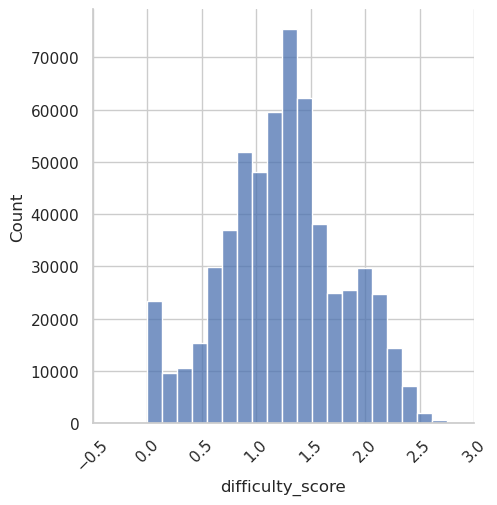

In [24]:
n = len(races_df)
num_bins = int(1 + np.log2(n))

g = seaborn.displot(races_df, x="difficulty_score", kind="hist", bins=num_bins)
g.set_xticklabels(rotation=45)
plt.show()


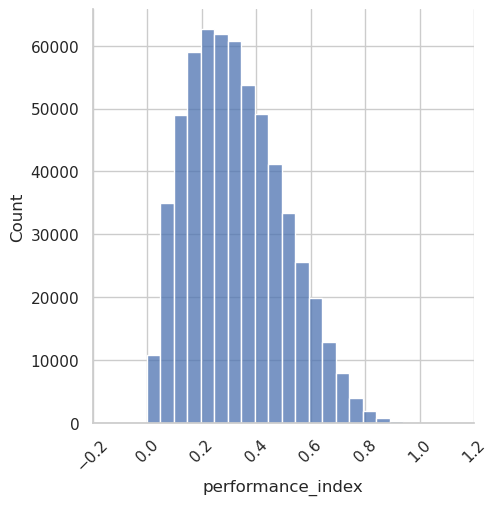

In [25]:
n = len(races_df)
num_bins = int(1 + np.log2(n))

g = seaborn.displot(races_df, x="performance_index", kind="hist", bins=num_bins)
g.set_xticklabels(rotation=45)
plt.show()


The data in `gain_ratio` is highly skewed, with the majority of values near zero and a few outliers at much higher values. This leads to an unbalanced histogram where most of the bins end up in the first interval. For this reason, we will use a logarithmic scale to better visualize the data.

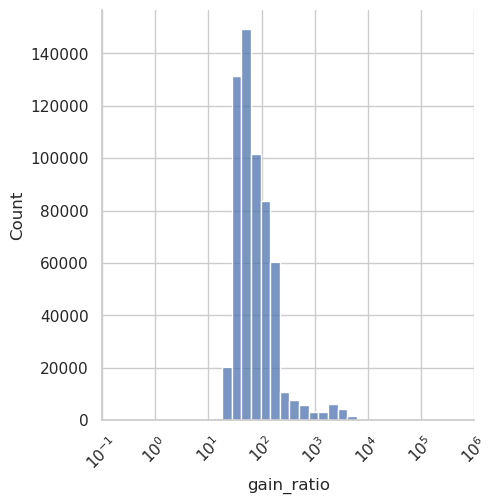

In [26]:
g = seaborn.displot(races_df, x="gain_ratio", kind="hist", bins=num_bins, log_scale=(True, False))
g.set_xticklabels(rotation=45)
plt.show()

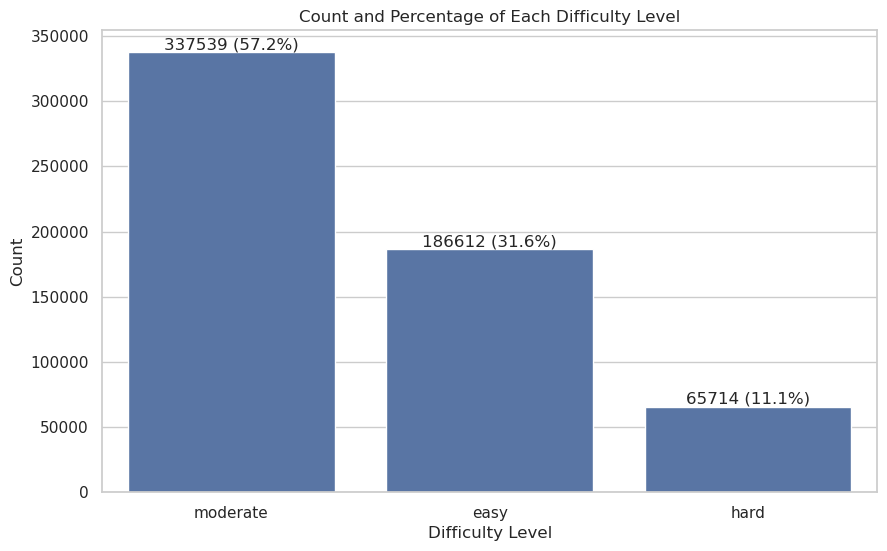

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate counts and percentages
difficulty_counts = races_df['difficulty_level'].value_counts()
difficulty_percentages = 100 * difficulty_counts / difficulty_counts.sum()

difficulty_data = (
    pd.DataFrame({'Count': difficulty_counts, 'Percentage': difficulty_percentages})
    .reset_index()
    .rename(columns={'index': 'difficulty_level'})
)

plt.figure(figsize=(10, 6))
sns.barplot(x='difficulty_level', y='Count', data=difficulty_data)  # Light blue color

# Annotate each bar with count and percentage
for index, row in difficulty_data.iterrows():
    plt.text(index, row['Count'], f"{row['Count']} ({row['Percentage']:.1f}%)", 
             ha='center', va='bottom')

plt.xlabel("Difficulty Level")
plt.ylabel("Count")
plt.title("Count and Percentage of Each Difficulty Level")
plt.show()


As you can see, most of the races (57.2%) in the dataset have a moderate difficulty according to our scoring system.

This difficulty level is followed by the easy (31.6%) and hard (11.1%) levels.

In [28]:
ENGINEERED_RACES_PATH=path.join('..','dataset','engineered_races.csv')
races_df.to_csv(ENGINEERED_RACES_PATH,index=False)